In [1]:
# Leave lines below uncommented this if you get:
# OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import torch.nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
from glomerulus import Glomerulus, Patch, KidneySampleDataset, get_glomeruli, generate_glomerulus_patches
from networks import CBAM_R2UNet_v2
from utils import read_tiff, dataset_label_mean
from losses import dice_loss

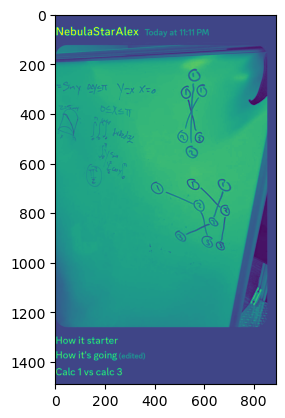

In [20]:
img = plt.imread('Screenshot_2023-11-06-23-15-46-93_572064f74bd5f9fa804b05334aa4f912.jpg')
plt.imshow(torch.sum(torch.tensor(np.transpose(img, (2, 0, 1))), 0))

torch.Size([1490, 889])

In [30]:
img_tensor = torch.unsqueeze(torch.unsqueeze(torch.sum(torch.tensor(np.transpose(img, (2, 0, 1))), 0), 0), 0).type(torch.cuda.FloatTensor)
out = model.forward(img_tensor)
see = model.transform_input(img_tensor)

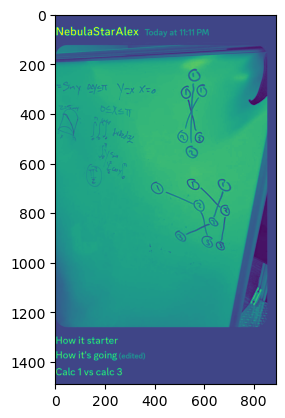

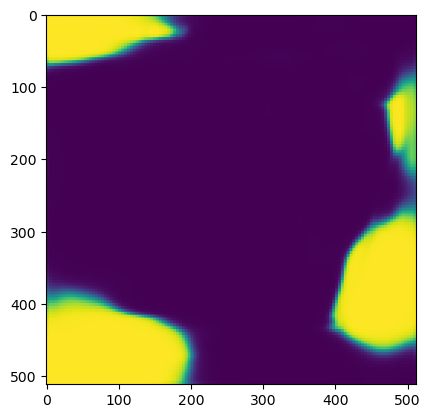

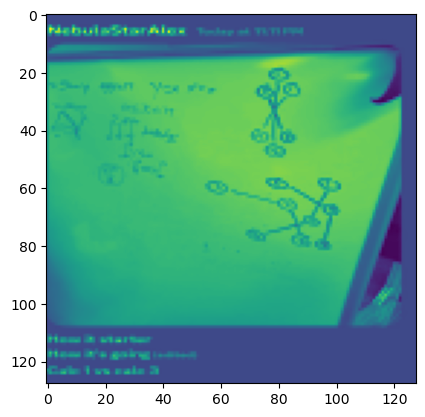

In [31]:
plt.imshow(torch.sum(torch.tensor(np.transpose(img, (2, 0, 1))), 0))
plt.show()
plt.imshow(out[0][0].cpu().detach().numpy())
plt.show()
plt.imshow(see[0][0].cpu().detach().numpy())
plt.show()

In [4]:
TEST_IMAGE_PATH = './kidney_dataset/train/aaa6a05cc.tiff'
TEST_LABEL_PATH = './kidney_dataset/train/aaa6a05cc.json'

test_image = read_tiff(TEST_IMAGE_PATH)


C:\Users\iraha\anaconda3\lib\site-packages\rasterio\__init__.py:320: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [62]:
test_glomeruli = get_glomeruli(TEST_LABEL_PATH,'glomerulus')
out_img = np.zeros((
    int(np.ceil(test_image.shape[1] / 512) * 512),
    int(np.ceil(test_image.shape[2] / 512) * 512)
))
for idx_y in tqdm(range(0, test_image.shape[1], 512)):
    for idx_x in range(0, test_image.shape[2], 512):
        center_x = idx_x + 512 // 2
        center_y = idx_y + 512 // 2
        test_patch = Patch(
            center_x = center_x,
            center_y = center_y,
            theta = 0,
            patch_size = 512,
            glomeruli = test_glomeruli,
            image = test_image
        ).render_image()
        out = model.forward(torch.unsqueeze(torch.tensor(test_patch), 0).type(torch.cuda.FloatTensor))
        out_img[idx_y: idx_y+512, idx_x: idx_x+512] = out.cpu().detach().numpy()[0][0]

  0%|          | 0/37 [00:00<?, ?it/s]

In [6]:
model = CBAM_R2UNet_v2((128, 128), (512, 512)).cuda()
model.load_state_dict(torch.load('./models/CBAM_R2UNet_v2_Weighted_BCE_Dice_t1000_best_loss.npz'))

<All keys matched successfully>

In [33]:
out = model.forward(torch.unsqueeze(torch.tensor(test_patch), 0).type(torch.cuda.FloatTensor))

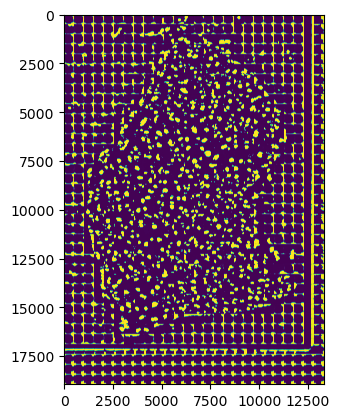

In [63]:
plt.imshow(out_img)

In [51]:
int(np.ceil(test_image.shape[1] / 512) * 512)

18944

In [48]:
test_image.shape[1]

18484

In [59]:
out_img[0: 0+512, 0: 0+512].shape

(512, 512)

In [110]:
import random
def generate_random_patches(patch_size, num_patches, glomeruli, image):
    patches = []
    for _ in tqdm(range(num_patches)):
        glomeruli_num = len(glomeruli)
        glomerulus = glomeruli[random.randrange(0, glomeruli_num)]
        
        center_x = random.randrange(
            patch_size // 2,
            image.shape[2] - patch_size // 2
        )
        
        center_y = random.randrange(
            patch_size // 2,
            image.shape[1] - patch_size // 2
        )
        
        theta = random.random()*360
        
        patches.append(Patch(
            center_x = center_x,
            center_y = center_y,
            theta = theta,
            patch_size = patch_size,
            glomeruli = glomeruli,
            image = image
        ))
    return patches

  0%|          | 0/100 [00:00<?, ?it/s]

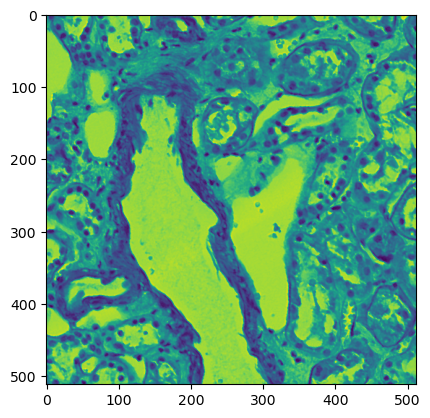

In [111]:
test_patches = generate_random_patches(
    patch_size = 512,
    num_patches = 100,
    glomeruli = test_glomeruli,
    image = test_image
)

for patch in test_patches:
    patch.render_image()
plt.imshow(test_patches[4].render_image()[0])

In [104]:
test_patches[2].center_x
# test_patches[2].center_y

4683

In [85]:
Patch(
    center_x = 14759,
    center_y = 8436,
    theta = 0,
    patch_size = 512,
    glomeruli = test_glomeruli,
    image = test_image
).render_image()

ValueError: could not broadcast input array from shape (1,1452,0) into shape (1,1452,431)

In [107]:
test_patches[4].center_x

15476